<a href="https://colab.research.google.com/github/kpr-03/DeepLearning_TensorFlow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with tensorFlow part 1: Feature extraction
Transfer learning is leaveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. can leverage an existing neural network architecture proven to work on problems similar to oue own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own,then we can adapt those patterns to our own data

In [1]:
# are we using GPU
!nvidia-smi

Thu Jul 20 11:07:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")

zip_ref.extractall()
zip_ref.close()


--2023-07-20 11:07:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   230MB/s    in 0.7s    

2023-07-20 11:07:01 (230 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# walk through 10 percent data directory and list number of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## creating data loaders(preparing the data)
We'll use the `ImageDatGenerator` class to load in our images in batches.

In [4]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")


print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size =IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# setting up callbacks(things to run whilst our model trains)

callbacks are extra functionality you can add to your models
to be performed during or after training.Some of the most popular callbacks:

* tracking experiments with TensorBoard callback
* Model checkpoint with ModelCheckpoint
* Stopping amodel from training(before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# create Tensorboard callback(functionized beacuse we need to create anew one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir= dir_name + "/" + experiment_name + "/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Savoing Tensorbaord log files to :{log_dir}")
  return tensorboard_callback


🔑**Note:** You can customize the directory where your TensorBoard logs(model training metics) get saved to whatever you like.The `log_dir`parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch

Now we're going to do a similar process,except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on : https://www.tensorflow.org/hub

Browsing the TensoFlow Hub page and sorting for image classification,we found the foloowingfeature vector model link:https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
#
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [7]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# let's make a create_model() function to create a model from URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and vreates a Keras Sequential moel with it.

  Args:
    model_url(str) : A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of ioutput neurons in the output layer,
    should be equal to number of target classes,default 10.

    Returns:
    An uncompiled Keras Sequential model with model_url as feature exrtractor
    layer and Dense output layer with num_classes output neurons.

  """
  # download the pre trained layer and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned pattern
                                           name="feature_extractor_layer",
                                           input_shape=IMG_SHAPE+(3,))

  # CREATE OUR OWN MODEL
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model

### Creating and testing ResNet TensorFlow Hub feature extraction model

In [9]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Savoing Tensorbaord log files to :tensorflow_hub/resnet50V2/20230720-110717
Epoch 1/5
24/24 [==============================] - 37s 927ms/step - loss: 1.9139 - accuracy: 0.3827 - val_loss: 1.2429 - val_accuracy: 0.6056
Epoch 2/5
24/24 [==============================] - 18s 787ms/step - loss: 0.9011 - accuracy: 0.7507 - val_loss: 0.8521 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 20s 838ms/step - loss: 0.6119 - accuracy: 0.8293 - val_loss: 0.7424 - val_accuracy: 0.7652
Epoch 4/5
24/24 [==============================] - 20s 863ms/step - loss: 0.4700 - accuracy: 0.8760 - val_loss: 0.7093 - val_accuracy: 0.7624
Epoch 5/5
24/24 [==============================] - 18s 781ms/step - loss: 0.3767 - accuracy: 0.9160 - val_loss: 0.6749 - val_accuracy: 0.7764


Wow!

That's incredible.our trahnsfer learning feature extractor model out performed ALL of the previous models we built by hand.....(substantially) and in a quicker training time AND with only 10% of training examples

In [12]:
#let's create a function tyo plot our loss curves....
# Tidbit: you could put a function like this into a scrit called "helper.py" and import
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



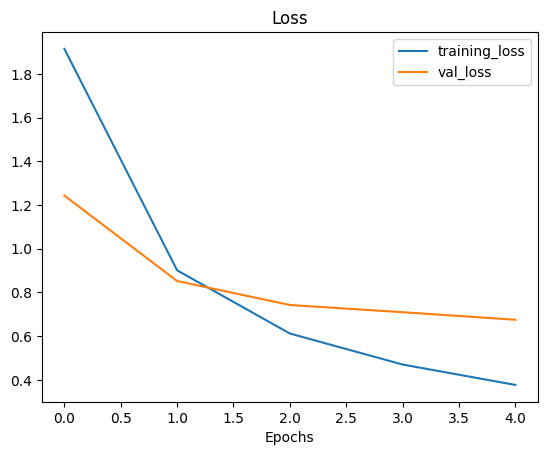

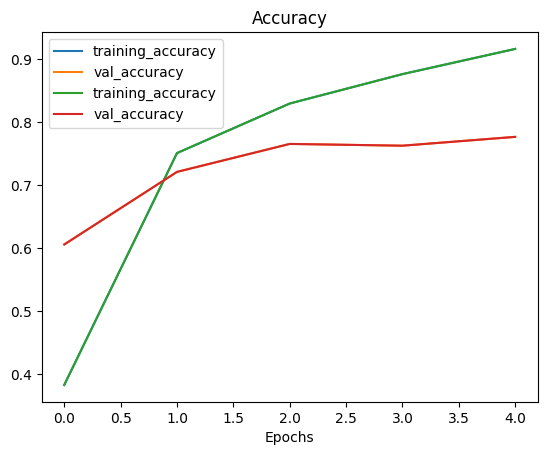

In [13]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 tensorflow Hub feature extraction model


In [14]:
# Create model setails on efficientnet:https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])


Savoing Tensorbaord log files to :tensorflow_hub/efficientnetB0/20230720-110923
Epoch 1/5
24/24 [==============================] - 29s 853ms/step - loss: 2.0281 - accuracy: 0.3160 - val_loss: 1.5747 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - 18s 777ms/step - loss: 1.3419 - accuracy: 0.6733 - val_loss: 1.1593 - val_accuracy: 0.7148
Epoch 3/5
24/24 [==============================] - 18s 760ms/step - loss: 1.0250 - accuracy: 0.7547 - val_loss: 0.9705 - val_accuracy: 0.7420
Epoch 4/5
24/24 [==============================] - 19s 808ms/step - loss: 0.8529 - accuracy: 0.7920 - val_loss: 0.8727 - val_accuracy: 0.7596
Epoch 5/5
24/24 [==============================] - 17s 746ms/step - loss: 0.7402 - accuracy: 0.8333 - val_loss: 0.8077 - val_accuracy: 0.7744


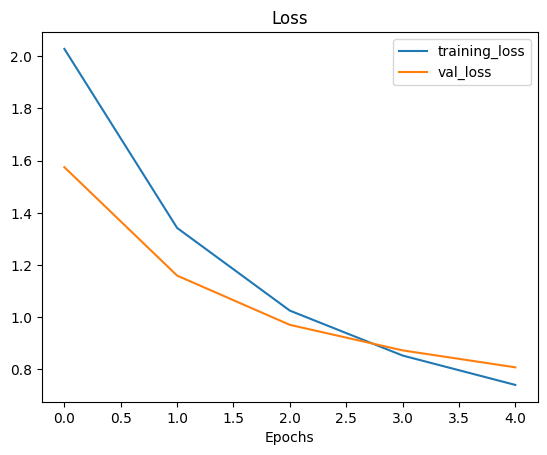

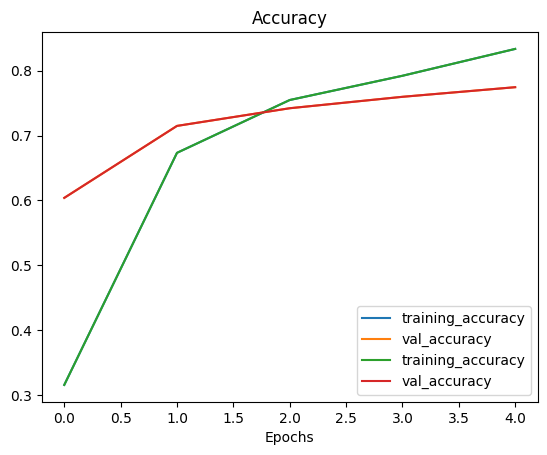

In [15]:

plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             5919312   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [17]:

# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-07-20 11:11:13.345746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   LNXS-FPRV



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

In [19]:
# check out what tensorboard experiments you have
!tensorboard dev list


2023-07-20 11:38:51.954054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/TjH71DVQRTe1QHB8onytYQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   TjH71DVQRTe1QHB8onytYQ
	Created              2023-07-20 11:35:58 (2 minutes ago)
	Updated              2023-07-20 11:36:00 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  4511490
https://tensorboard.dev/experiment/w1GPf49uRVGAgWu7PJxeww/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   w1GPf49uRVGAgWu7PJxeww
	Created              2023-07-18 11:35:38
	Updated              2023-07-18 11

In [20]:
# Delete an experiment
#!tensorboard dev delete --experiment_id TjH71DVQRTe1QHB8onytYQ